In [1]:
!pip install scikit-survival lifelines


In [29]:


# ## packages 
 
from graphviz import Digraph
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from lifelines import LogNormalAFTFitter
from graphviz import Digraph
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, roc_curve
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from lifelines import CoxPHFitter
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import warnings
import os
warnings.filterwarnings('ignore')
from sksurv.metrics import integrated_brier_score
import warnings
warnings.filterwarnings('ignore')



# #  Set number of cores for parallel processing
N_JOBS = -1  

# Top N features to select from RSF (it can be a)
TOP_N_FEATURES = 50  ## we can change to 30, 75, 100

# Output directory
OUTPUT_DIR = "/Users/joshkorley/Documents/ENAR_project/"



In [3]:
import os

## confirm directory , it works on my pc so to yours ... not needed though
print("Current directory:", os.getcwd())

try:
    files = os.listdir("/Users/joshkorley/Documents")
    for f in files:
        print(f"  {f}")
except:
    print("  Can't access /Users/joshkorley/Documents")

print("\nChecking ENAR_project folder:")
try:
    files = os.listdir("/Users/joshkorley/Documents/ENAR_project")
    print(f"  Found {len(files)} files/folders")
    for f in files:
        print(f"  {f}")
except:
    print("  ENAR_project folder doesn't exist!")




Current directory: /Users/joshkorley/Documents/ENAR_project
  .Rhistory
  Forest
  Algoverse.mov
  forcast
  .DS_Store
  ghana
  MentalHealthProject
  ENAR_project
  .localized
  CAUSAL INF IN BIOMEDICAL DATA
  STAT5820
  PIWC
  METHODOLOGY_CRITERION
  Website
  Extra Docs
  Game
  SURVIVAL ANALYSIS
  scoresheet
  PASSPOR PICTURES
  Causal Inference
  Joshwebsite
  Times Series 
  .RData
  STAT5870
  Functional Data Analysis_Reseearch
  Documents.Rproj
  MUSIC_2025
  .Rproj.user
  STAT- COMPUTER BASE
  Grad App, 25
  SHare

Checking ENAR_project folder:
  Found 25 files/folders
  merged_1_4.csv
  merged_clinical.csv
  clinical_integrat.csv
  .DS_Store
  features_RSF.ipynb
  Untitled.ipynb
  X_mRNA_pruned_integrated.csv
  features_RSF.html
  omics_full_pipeline_horizontal
  X_mRNA_pruned1.csv
  X_meth_pruned.csv
  TopFeatures_C1_Case1.csv
  clinical_integrate.csv
  X_mRNA_pruned_overall.csv
  TopFeatures_C1_Case2.csv
  clinical_overall.csv
  X_meth_pruned1.csv
  X_meth_pruned_integrated

In [5]:
X_meth_integrated = pd.read_csv(f"{OUTPUT_DIR}X_meth_pruned_integrated.csv")
X_mRNA_integrated = pd.read_csv(f"{OUTPUT_DIR}X_mRNA_pruned_integrated.csv")
X_mRNA_overall = pd.read_csv(f"{OUTPUT_DIR}X_mRNA_pruned_overall.csv")
clinical_full = pd.read_csv(f"{OUTPUT_DIR}merged_clinical.csv")
clinical_inte = pd.read_csv(f"{OUTPUT_DIR}clinical_integrate.csv")

print(f"\n Data loaded:")
print(f"  Cohort 1 (Integrated): N={len(X_meth_integrated)}")
print(f"  Cohort 2 (mRNA-only): N={len(X_mRNA_overall)}")
print(f"  Methylation features: {X_meth_integrated.shape[1]}")
print(f"  mRNA features (integrated): {X_mRNA_integrated.shape[1]}")
print(f"  mRNA features (overall): {X_mRNA_overall.shape[1]}")



✓ Data loaded:
  Cohort 1 (Integrated): N=1417
  Cohort 2 (mRNA-only): N=1980
  Methylation features: 8738
  mRNA features (integrated): 9793
  mRNA features (overall): 9894


In [6]:
# PREPARE CLINICAL DATA- the survival status and time for each cohort

# Standardize column names
clinical_full = clinical_full.rename(columns={
    'Overall Survival (Months)': 'OS_MONTHS',
    'Overall Survival Status': 'OS_STATUS'
})
clinical_inte = clinical_inte.rename(columns={
    'Overall Survival (Months)': 'OS_MONTHS',
    'Overall Survival Status': 'OS_STATUS'
})

def fix_os_status(df):
    if df['OS_STATUS'].dtype == 'object':
        df['OS_STATUS'] = df['OS_STATUS'].map({
            '0:LIVING': 0, '1:DECEASED': 1,
            'LIVING': 0, 'DECEASED': 1,
            0: 0, 1: 1
        })
    return df

clinical_full = fix_os_status(clinical_full)
clinical_inte = fix_os_status(clinical_inte)

# # Verify
assert 'OS_MONTHS' in clinical_full.columns
assert 'OS_STATUS' in clinical_full.columns
assert 'OS_MONTHS' in clinical_inte.columns
assert 'OS_STATUS' in clinical_inte.columns
assert clinical_full['OS_STATUS'].isin([0,1]).all()
assert clinical_inte['OS_STATUS'].isin([0,1]).all()

# ## Create survival outcomes
clinical_c1 = clinical_inte.copy()
y_c1 = Surv.from_dataframe(event='OS_STATUS', time='OS_MONTHS', data=clinical_c1)

clinical_c2 = clinical_full.copy()
y_c2 = Surv.from_dataframe(event='OS_STATUS', time='OS_MONTHS', data=clinical_c2)

print(f"\n Cohorts prepared:")
print(f"  Cohort 1: {len(clinical_c1)} samples, {y_c1['OS_STATUS'].sum()} events")
print(f"  Cohort 2: {len(clinical_c2)} samples, {y_c2['OS_STATUS'].sum()} events")



✓ Cohorts prepared:
  Cohort 1: 1417 samples, 826 events
  Cohort 2: 1980 samples, 1143 events


In [7]:
# UNIVARIATE COX FUNCTION

def univariate_cox_filter(X, clinical_data, top_n=500, data_name=""):
    """Univariate Cox for feature selection"""
    print(f"\n  Running univariate Cox on {X.shape[1]} {data_name} features...")
    results = []
    
    total = X.shape[1]
    checkpoint = max(1, total // 10)
    failed = 0
    
    for i, col in enumerate(X.columns):
        if (i + 1) % checkpoint == 0:
            print(f"    Progress: {i+1}/{total} ({(i+1)/total*100:.0f}%)")
        
        try:
            temp_df = pd.DataFrame({
                'feature': X[col].values,
                'OS_MONTHS': clinical_data['OS_MONTHS'].values,
                'OS_STATUS': clinical_data['OS_STATUS'].values
            }).dropna()
            
            if temp_df['feature'].std() == 0 or len(temp_df) < 10:
                failed += 1
                continue
            
            cph = CoxPHFitter(penalizer=0.01)
            cph.fit(temp_df, duration_col='OS_MONTHS', event_col='OS_STATUS')
            
            results.append({
                'feature_idx': i,
                'feature_name': col,
                'HR': cph.summary['exp(coef)'].values[0],
                'p_value': cph.summary['p'].values[0]
            })
        except:
            failed += 1
            continue
    
    results_df = pd.DataFrame(results)
    
    if len(results_df) == 0:
        print(f"    No features passed!")
        return pd.DataFrame()
    
    results_df = results_df.sort_values('p_value').head(top_n)
    print(f"     Selected {len(results_df)} features (p: {results_df['p_value'].min():.2e} to {results_df['p_value'].max():.2e})")
    
    return results_df

#  RSF WITH PERMUTATION IMPORTANCE - for feature selection

def train_rsf_permutation(X, y, case_name="", n_top=50):
    """Train RSF with permutation importance"""
    print(f"\n  Training RSF on {X.shape[1]} features...")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=89, stratify=y['OS_STATUS']
    )
    
    print(f"    Train: {len(X_train)}, Test: {len(X_test)}")
    
    rsf = RandomSurvivalForest(
        n_estimators=500,
        min_samples_split=10,
        min_samples_leaf=20,
        max_features="sqrt",
        n_jobs=N_JOBS,
        random_state=89,
        max_depth=5,
        verbose=0
    )
    
    rsf.fit(X_train, y_train)
    print(f"    RSF trained")
    
    print(f"    Calculating permutation importance...")
    perm_imp = permutation_importance(
        rsf, X_test, y_test,
        n_repeats=10,
        random_state=89,
        n_jobs=N_JOBS
    )
    
    importance_df = pd.DataFrame({
        'feature_name': X.columns,
        'importance': perm_imp.importances_mean,
        'importance_std': perm_imp.importances_std
    }).sort_values('importance', ascending=False)
    
    importance_file = f"{OUTPUT_DIR}Importance_{case_name}.csv"
    importance_df.to_csv(importance_file, index=False)
    print(f"    Importance saved: Importance_{case_name}.csv")
    
    top_features = importance_df.head(n_top)
    print(f"    Top {n_top} features selected")
    print(f"      Top: {top_features.iloc[0]['feature_name']} (imp={top_features.iloc[0]['importance']:.6f})")
    
    return top_features, X_train, X_test, y_train, y_test, importance_df

In [9]:
# EVALUATION FUNCTION to compute  ibs , cindex and auc

def evaluate_cox_model(X_train_selected, X_test_selected, 
                        y_train, y_test, clinical_c_train, clinical_c_test, case_name=""):
    """
    Fit Cox model on selected features ONLY
    Strategy 3 features evaluated independently
    """
    
    print(f"\n  Evaluating: {case_name}")
    print(f"    Features: {X_train_selected.shape[1]} (Strategy 3 only)")
    
    # Prepare data
    train_df = X_train_selected.copy()
    train_df['OS_MONTHS'] = clinical_c_train['OS_MONTHS'].values
    train_df['OS_STATUS'] = clinical_c_train['OS_STATUS'].values
    
    # # Fit Cox
    cph = CoxPHFitter(penalizer=0.01)
    cph.fit(train_df, duration_col='OS_MONTHS', event_col='OS_STATUS')
    
    # # Predict
    risk_train = cph.predict_partial_hazard(X_train_selected)
    risk_test = cph.predict_partial_hazard(X_test_selected)
    
    # #C-index
    c_train = concordance_index(
        clinical_c_train['OS_MONTHS'], -risk_train, clinical_c_train['OS_STATUS']
    )
    c_test = concordance_index(
        clinical_c_test['OS_MONTHS'], -risk_test, clinical_c_test['OS_STATUS']
    )
    
    # # AUC
    median_time = clinical_c_train['OS_MONTHS'].median()
    y_binary_test = (
        (clinical_c_test['OS_STATUS'] == 1) & 
        (clinical_c_test['OS_MONTHS'] < median_time)
    ).astype(int)
    
    auc_test = roc_auc_score(y_binary_test, risk_test) if len(np.unique(y_binary_test)) > 1 else np.nan
    
    # # IBS
    try:
        times = np.percentile(clinical_c_test['OS_MONTHS'].dropna(), np.linspace(5, 95, 20))
        times = times[times > 0]
        surv_funcs_test = cph.predict_survival_function(X_test_selected, times=times)
        surv_probs = np.column_stack([surv_funcs_test[col] for col in surv_funcs_test.columns])
        ibs_test = integrated_brier_score(y_train, y_test, surv_probs, times)
    except:
        ibs_test = np.nan
    
    print(f"    C-index (train): {c_train:.4f}")
    print(f"    C-index (test): {c_test:.4f}")
    if not np.isnan(auc_test):
        print(f"    AUC (test): {auc_test:.4f}")
    if not np.isnan(ibs_test):
        print(f"    IBS (test): {ibs_test:.4f}")
    
    return {
        'model': case_name,
        'n_features': X_train_selected.shape[1],
        'c_index_train': c_train,
        'c_index_test': c_test,
        'auc_test': auc_test,
        'ibs_test': ibs_test
    }


In [10]:

# COHORT 1: INTEGRATED (N=1417)
# ==============================  ===


print(" COHORT 1: INTEGRATED (N=1417) ".center(67, "="))
print("="*60)

results_c1 = []

# C1 CASE 1: Separate Cox -> Combine -- >RSF


print(" CASE 1: Separate Cox → Combine → RSF ".center(69, "-"))
print("-"*60)

cox_mrna_c1 = univariate_cox_filter(X_mRNA_integrated, clinical_c1, top_n=500, data_name="mRNA")
cox_meth_c1 = univariate_cox_filter(X_meth_integrated, clinical_c1, top_n=500, data_name="Methylation")

X_mrna_sel = X_mRNA_integrated.iloc[:, cox_mrna_c1['feature_idx'].values]
X_meth_sel = X_meth_integrated.iloc[:, cox_meth_c1['feature_idx'].values]
X_combined_case1 = pd.concat([X_mrna_sel, X_meth_sel], axis=1)

print(f"\n  Combined: {X_combined_case1.shape[1]} features")

top_c1_case1, X_train, X_test, y_train, y_test, imp_c1_case1 = train_rsf_permutation(
    X_combined_case1, y_c1, case_name="C1_Case1_SeparateCox", n_top=TOP_N_FEATURES
)

clin_train = clinical_c1.iloc[X_train.index]
clin_test = clinical_c1.iloc[X_test.index]

X_train_top = X_train[top_c1_case1['feature_name']]
X_test_top = X_test[top_c1_case1['feature_name']]

result = evaluate_cox_model(
    X_train_top, X_test_top, y_train, y_test, clin_train, clin_test,
    "C1-Case1: Separate Cox"
)
results_c1.append(result)

top_c1_case1.to_csv(f"{OUTPUT_DIR}TopFeatures_C1_Case1.csv", index=False)



======================== COHORT 1: INTEGRATED (N=1417) =========================

--------------------------------------------------------------------------------
--------------------- CASE 1: Separate Cox → Combine → RSF ---------------------
--------------------------------------------------------------------------------

  Running univariate Cox on 9793 mRNA features...
    Progress: 979/9793 (10%)
    Progress: 1958/9793 (20%)
    Progress: 2937/9793 (30%)
    Progress: 3916/9793 (40%)
    Progress: 4895/9793 (50%)
    Progress: 5874/9793 (60%)
    Progress: 6853/9793 (70%)
    Progress: 7832/9793 (80%)
    Progress: 8811/9793 (90%)
    Progress: 9790/9793 (100%)
    ✓ Selected 500 features (p: 2.51e-09 to 1.79e-03)

  Running univariate Cox on 8738 Methylation features...
    Progress: 873/8738 (10%)
    Progress: 1746/8738 (20%)
    Progress: 2619/8738 (30%)
    Progress: 3492/8738 (40%)
    Progress: 4365/8738 (50%)
    Progress: 5238/8738 (60%)
    Progress: 6111/8738 (70%)
 

In [11]:
# C1 CASE 2: Combine _> Cox -> RSF


print(" CASE 2: Combine → Cox → RSF ".center(67, "-"))
print("-"*60)

X_combined_full = pd.concat([X_mRNA_integrated, X_meth_integrated], axis=1)
print(f"\n  Combined dataset: {X_combined_full.shape[1]} features")

cox_combined = univariate_cox_filter(X_combined_full, clinical_c1, top_n=1000, data_name="Combined")

X_combined_case2 = X_combined_full.iloc[:, cox_combined['feature_idx'].values]

top_c1_case2, X_train, X_test, y_train, y_test, imp_c1_case2 = train_rsf_permutation(
    X_combined_case2, y_c1, case_name="C1_Case2_CombinedCox", n_top=TOP_N_FEATURES
)

clin_train = clinical_c1.iloc[X_train.index]
clin_test = clinical_c1.iloc[X_test.index]

X_train_top = X_train[top_c1_case2['feature_name']]
X_test_top = X_test[top_c1_case2['feature_name']]

result = evaluate_cox_model(
    X_train_top, X_test_top, y_train, y_test, clin_train, clin_test,
    "C1-Case2: Combined Cox"
)
results_c1.append(result)

top_c1_case2.to_csv(f"{OUTPUT_DIR}TopFeatures_C1_Case2.csv", index=False)



--------------------------------------------------------------------------------
------------------------- CASE 2: Combine → Cox → RSF --------------------------
--------------------------------------------------------------------------------

  Combined dataset: 18531 features

  Running univariate Cox on 18531 Combined features...
    Progress: 1853/18531 (10%)
    Progress: 3706/18531 (20%)
    Progress: 5559/18531 (30%)
    Progress: 7412/18531 (40%)
    Progress: 9265/18531 (50%)
    Progress: 11118/18531 (60%)
    Progress: 12971/18531 (70%)
    Progress: 14824/18531 (80%)
    Progress: 16677/18531 (90%)
    Progress: 18530/18531 (100%)
    ✓ Selected 1000 features (p: 2.51e-09 to 3.70e-03)

  Training RSF on 1000 features...
    Train: 991, Test: 426
    ✓ RSF trained
    Calculating permutation importance...
    ✓ Importance saved: Importance_C1_Case2_CombinedCox.csv
    ✓ Top 50 features selected
      Top: TPD52L1_mrna (imp=0.001654)

  Evaluating: C1-Case2: Combined Cox
   

In [12]:

# COHORT 2: mRNA-ONLY (1980 featurews)
# ==============================================================================

print("\n\n" + "="*80)
print(" COHORT 2: mRNA-ONLY (N=1980) ".center(80, "="))
print("="*80)

results_c2 = []

# C2 CASE 1: mRNA Only


print(" CASE 1: mRNA Only ".center(74, "-"))
print("-"*60)

cox_mrna_c2 = univariate_cox_filter(X_mRNA_overall, clinical_c2, top_n=500, data_name="mRNA")

X_mrna_c2_sel = X_mRNA_overall.iloc[:, cox_mrna_c2['feature_idx'].values]

top_c2_case1, X_train, X_test, y_train, y_test, imp_c2_case1 = train_rsf_permutation(
    X_mrna_c2_sel, y_c2, case_name="C2_Case1_mRNA_only", n_top=TOP_N_FEATURES
)

clin_train = clinical_c2.iloc[X_train.index]
clin_test = clinical_c2.iloc[X_test.index]

X_train_top = X_train[top_c2_case1['feature_name']]
X_test_top = X_test[top_c2_case1['feature_name']]

result = evaluate_cox_model(
    X_train_top, X_test_top, y_train, y_test, clin_train, clin_test,
    "C2-Case1: mRNA only"
)
results_c2.append(result)

top_c2_case1.to_csv(f"{OUTPUT_DIR}TopFeatures_C2_Case1.csv", index=False)



========================= COHORT 2: mRNA-ONLY (N=1980) =========================

--------------------------------------------------------------------------------
------------------------------ CASE 1: mRNA Only -------------------------------
--------------------------------------------------------------------------------

  Running univariate Cox on 9894 mRNA features...
    Progress: 989/9894 (10%)
    Progress: 1978/9894 (20%)
    Progress: 2967/9894 (30%)
    Progress: 3956/9894 (40%)
    Progress: 4945/9894 (50%)
    Progress: 5934/9894 (60%)
    Progress: 6923/9894 (70%)
    Progress: 7912/9894 (80%)
    Progress: 8901/9894 (90%)
    Progress: 9890/9894 (100%)
    ✓ Selected 500 features (p: 3.56e-14 to 1.12e-04)

  Training RSF on 500 features...
    Train: 1386, Test: 594
    ✓ RSF trained
    Calculating permutation importance...
    ✓ Importance saved: Importance_C2_Case1_mRNA_only.csv
    ✓ Top 50 features selected
      Top: PREX1_mrna (imp=0.001433)

  Evaluating: C2-Ca

In [13]:

# FINAL COMPARISON - here we want to compare the metrics for each of the models under the cohorts and cases



print(" FINAL RESULTS ".center(76, "="))
print("="*67)

all_results = []

for r in results_c1:
    all_results.append({
        'Cohort': 'Integrated (N=1417)',
        **r
    })

for r in results_c2:
    all_results.append({
        'Cohort': 'mRNA-only (N=1980)',
        **r
    })

comparison_df = pd.DataFrame(all_results)

print("\n" + comparison_df.to_string(index=False))

# # Best model
best_model = comparison_df.loc[comparison_df['c_index_test'].idxmax()]


print(" BEST MODEL ".center(70, "="))
print("="*60)
print(f"\n BEST PERFORMING MODEL:")
print(f"   {best_model['Cohort']} - {best_model['model']}")
print(f"   Features: {best_model['n_features']}")
print(f"   C-index: {best_model['c_index_test']:.4f}")
print(f"   AUC: {best_model['auc_test']:.4f}")
print(f"   IBS: {best_model['ibs_test']:.4f}")



================================ FINAL RESULTS =================================

             Cohort                  model  n_features  c_index_train  c_index_test  auc_test  ibs_test
Integrated (N=1417) C1-Case1: Separate Cox          50       0.671524      0.659359  0.720356       NaN
Integrated (N=1417) C1-Case2: Combined Cox          50       0.693196      0.657234  0.707887       NaN
 mRNA-only (N=1980)    C2-Case1: mRNA only          50       0.676408      0.625483  0.658057       NaN

================================== BEST MODEL ==================================

🏆 BEST PERFORMING MODEL:
   Integrated (N=1417) - C1-Case1: Separate Cox
   Features: 50
   C-index: 0.6594
   AUC: 0.7204
   IBS: nan


In [14]:
# Save
comparison_df.to_csv(f"{OUTPUT_DIR}Strategy3_Final_Comparison.csv", index=False)

print("\n✓ Results saved to Strategy3_Final_Comparison.csv")

print("\n" + "="*80)
print(" COMPLETE! ".center(80, "="))
print("="*80)

print(f"\n ANALYSIS SUMMARY:")
print(f"   Top N features selected: {TOP_N_FEATURES}")
print(f"   Total models compared: {len(comparison_df)}")
print(f"   Strategy 3 features evaluated independently from Strategy 1+2 (GWAS)")

print(f"\n KEY FINDINGS:")
print(f"   Best cohort: {best_model['Cohort']}")
print(f"   Best strategy: {best_model['model']}")
print(f"   Performance: C-index={best_model['c_index_test']:.4f}, AUC={best_model['auc_test']:.4f}, IBS={best_model['ibs_test']:.4f}")




✓ Results saved to Strategy3_Final_Comparison.csv

================================== COMPLETE! ===================================

📊 ANALYSIS SUMMARY:
   Top N features selected: 50
   Total models compared: 3
   Strategy 3 features evaluated independently from Strategy 1+2 (GWAS)

💡 KEY FINDINGS:
   Best cohort: Integrated (N=1417)
   Best strategy: C1-Case1: Separate Cox
   Performance: C-index=0.6594, AUC=0.7204, IBS=nan

📝 NEXT STEPS:
   1. Review Strategy3_Final_Comparison.csv for all results
   2. Compare Strategy 3 features with Strategy 1+2 (GWAS) features
   3. Use top features for deep learning with clinical variables
   4. Optionally take union of Strategy 1+2+3 features for final model


In [ ]:


analyze_feature_types(
    top_features_cox, 
    X_meth_cox.shape[1],
    title="Cox + RSF: Feature Type Breakdown"
)

In [ ]:

# top most important features

top_50 = top_features_cox.head(50).copy()


print(" TOP 50 MOST IMPORTANT FEATURES ".center(80, "="))
print("-"*80)


print(f"\n{'Rank':<6} {'Feature Name':<30} {'Importance':<12} {'Type':<15}")
print("-"*80)

for rank, (idx, row) in enumerate(top_50.iterrows(), 1):
    
    if '_methy' in row['feature_name']:
        feature_type = 'Methylation'
    elif '_mrna' in row['feature_name']:
        feature_type = 'mRNA'
    else:
        feature_type = 'Unknown'
    
    print(f"{rank:<6} {row['feature_name']:<30} {row['importance']:<12.6f} {feature_type:<15}")


n_meth_top50 = sum('_methy' in name for name in top_50['feature_name'])
n_mrna_top50 = sum('_mrna' in name for name in top_50['feature_name'])

print("\n" + "="*80)
print(f"Top 50 Breakdown:")
print(f"  Methylation: {n_meth_top50} ({n_meth_top50/50*100:.1f}%)")
print(f"  mRNA:        {n_mrna_top50} ({n_mrna_top50/50*100:.1f}%)")
print("="*80)


top_50.to_csv(
    "/Users/joshkorley/Documents/ENAR_project/Top_50_features_Cox_RSF.csv",
    index=False
)


In [ ]:
analyze_feature_types(
    top_50, 
    X_meth_cox.shape[1],
    title="Cox + RSF: Feature Type Breakdown"
)

In [ ]:
# Response
y = Surv.from_dataframe(
    event="OS_STATUS",
    time="OS_MONTHS",
    data=clinical
)


X = X_combined_cox.iloc[:, top_50["feature_idx"].values].copy()

X = X.select_dtypes(include="number")



In [ ]:
assert X.shape[0] == len(y), "Mismatch between X and y"
assert X.shape[1] == len(top_50), "Feature selection mismatch"


X = X.select_dtypes(include="number")

df_life = X.copy()
df_life["OS_MONTHS"] = y["OS_MONTHS"]
df_life["OS_STATUS"] = y["OS_STATUS"].astype(int)


In [ ]:
cph = CoxPHFitter()
cph.fit(df_life, duration_col="OS_MONTHS", event_col="OS_STATUS")
cph.print_summary()
cph.print_summary()


In [ ]:
cph.check_assumptions(df_life, p_value_threshold=0.05)


In [ ]:
cox_cindex = concordance_index(
    df_life["OS_MONTHS"],
    -cph.predict_partial_hazard(df_life),
    df_life["OS_STATUS"]
)

print(f"Cox PH C-index: {cox_cindex:.3f}")


In [ ]:
## The flow we have in the manuscript

dot = Digraph(comment='Omics Survival Pipeline', format='png')
dot.attr(rankdir='TB')  # horizontal flow

#  Raw data
dot.node('Raw', 'Raw Features\nTotal: 33,790\nmRNA: 20,603\nMethylation: 13,187',
         shape='box', style='filled', fillcolor='lightgray', width='2', fixedsize='false')

# ## Unsupervised Feature Screening
unsup_text = ("Unsupervised Feature Screening:\n"
              "- Exclude >30% missing (n=3,716)\n"
              "- Exclude low variance (<20%)\n"
              "  * mRNA 4,121, Methy 1,895\n"
              "- Mean imputation\n"
              "- Standardize to N(0,1)\n"
              "- Exclude high correlation (> 0.5)\n"
              "  * mRNA 6,588, Methy 1,573\n"
              "- Output: mRNA 9,894, Methy 6,003")
dot.node('Unsup', unsup_text, shape='box', style='filled', fillcolor='lightyellow', width='3', fixedsize='false')

#  ### Univariate Cox
dot.node('UniCox', 'Separate Univariate Cox\nTop 500 mRNA & 500 Methy',
         shape='box', style='filled', fillcolor='lightgreen', width='2.5', fixedsize='false')

#  #Combine Features
dot.node('Combine', 'Combine Top Features\n1k Features (500+500)',
         shape='box', style='filled', fillcolor='lightcyan', width='2.5', fixedsize='false')

#  Random Survival Forest
dot.node('RSF', 'Random Survival Forest\n- Rank features\n-Most mRNA features\n ranks higher',
         shape='box', style='filled', fillcolor='lavender', width='2.5', fixedsize='false')

#  Top-N Features
dot.node('TopN', 'Select Top-N Features\nN=30,50,100,200\nMonitor C-index', 
         shape='box', style='filled', fillcolor='wheat', width='2.5', fixedsize='false')

# ## Cox PH Modeling
cox_text = ("Cox PH Model:\n"
            "- C-index moves:\n"
            "  30 → 0.66\n"
            "  50 → 0.67\n"
            "  100 → 0.69\n"
            "  200 → 0.707 (plateau)\n"
            "- PH violations flagged")
dot.node('Cox', cox_text, shape='box', style='filled', fillcolor='mistyrose', width='3', fixedsize='false')

#  # Final Recommendation
dot.node('Final', 'Recommended: Top 50–100 Features\nBalanced Performance & Interpretability',
         shape='box', style='filled', fillcolor='lightblue', width='2.5', fixedsize='false')

# ### Connect horizontally
dot.edges([('Raw','Unsup'), ('Unsup','UniCox'), ('UniCox','Combine'), 
           ('Combine','RSF'), ('RSF','TopN'), ('TopN','Cox'), ('Cox','Final')])


dot.render('omics_pipeline_horizontal_verticalboxes', view=True)
print("Flowchart generated as 'omics_pipeline_horizontal_verticalboxes.png'")




In [ ]:
# ##  save results


print(" SAVING RESULTS ".center(80, "="))
print("="*80)

# # Selected features
top_features_cox.to_csv(
    "/Users/joshkorley/Documents/ENAR_project/RSF_selected_features_cox_method.csv", 
    index=False
)
print(" Cox + RSF selected features")


top_features_all.to_csv(
    "/Users/joshkorley/Documents/ENAR_project/RSF_selected_features_direct_method.csv", 
    index=False
)


# Full importance rankings
importance_cox.to_csv(
    "/Users/joshkorley/Documents/ENAR_project/RSF_importance_all_cox_method.csv", 
    index=False
)

print(" Cox + RSF full importance")

importance_all.to_csv(
    "/Users/joshkorley/Documents/ENAR_project/RSF_importance_all_direct_method.csv", 
    index=False
)







In [17]:
 #Different top N values to test
TOP_N_VALUES = [50, 100, 150, 200, 300]


print(" SENSITIVITY ANALYSIS: Top N Features ".center(70, "="))
print("="*60)

#  imporatnce data frame

print("\nLoading data and importance rankings")

# ## load original data
X_meth_integrated = pd.read_csv(f"{OUTPUT_DIR}X_meth_pruned_integrated.csv")
X_mRNA_integrated = pd.read_csv(f"{OUTPUT_DIR}X_mRNA_pruned_integrated.csv")
X_mRNA_overall = pd.read_csv(f"{OUTPUT_DIR}X_mRNA_pruned_overall.csv")

# # ## clinical-  just trying to create time and status again
clinical_inte = pd.read_csv(f"{OUTPUT_DIR}clinical_integrate.csv")
clinical_full = pd.read_csv(f"{OUTPUT_DIR}merged_clinical.csv")

# # Fix column names- survvil status for integrated and overall for the sensitivity analysis
clinical_inte = clinical_inte.rename(columns={
    'Overall Survival (Months)': 'OS_MONTHS',
    'Overall Survival Status': 'OS_STATUS'
})
clinical_full = clinical_full.rename(columns={
    'Overall Survival (Months)': 'OS_MONTHS',
    'Overall Survival Status': 'OS_STATUS'
})

===================== SENSITIVITY ANALYSIS: Top N Features =====================

Loading data and importance rankings...


In [18]:
def fix_os_status(df):
    if df['OS_STATUS'].dtype == 'object':
        df['OS_STATUS'] = df['OS_STATUS'].map({
            '0:LIVING': 0, '1:DECEASED': 1,
            'LIVING': 0, 'DECEASED': 1,
            0: 0, 1: 1
        })
    return df

clinical_c1 = fix_os_status(clinical_inte.copy())
clinical_c2 = fix_os_status(clinical_full.copy())

y_c1 = Surv.from_dataframe(event='OS_STATUS', time='OS_MONTHS', data=clinical_c1)
y_c2 = Surv.from_dataframe(event='OS_STATUS', time='OS_MONTHS', data=clinical_c2)

# # Load importance rankings (already calculated!)
imp_c1_case1 = pd.read_csv(f"{OUTPUT_DIR}Importance_C1_Case1_SeparateCox.csv")
imp_c1_case2 = pd.read_csv(f"{OUTPUT_DIR}Importance_C1_Case2_CombinedCox.csv")
imp_c2_case1 = pd.read_csv(f"{OUTPUT_DIR}Importance_C2_Case1_mRNA_only.csv")

print(" Data and importance rankings loaded!")

✓ Data and importance rankings loaded!


In [35]:
def evaluate_top_n(X_full, y, clinical_data, importance_df, top_n, case_name):
    """
    Evaluate model performance with top N features
    Uses pre-calculated importance rankings
    """
    
    # #Select top N features
    top_features = importance_df.head(top_n)['feature_name'].values
    
    # Filter to only features that exist in X_full
    available_features = [f for f in top_features if f in X_full.columns]
    
    if len(available_features) == 0:
        return None
    
    X_selected = X_full[available_features]
    
    # # Train-test split (same random state as original)
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.3, random_state=42, stratify=y['OS_STATUS']
    )
    
    clinical_train = clinical_data.iloc[X_train.index]
    clinical_test = clinical_data.iloc[X_test.index]
    
    # # Prepare data for Cox
    train_df = X_train.copy()
    train_df['OS_MONTHS'] = clinical_train['OS_MONTHS'].values
    train_df['OS_STATUS'] = clinical_train['OS_STATUS'].values
    
    # # Fit Cox
    try:
        cph = CoxPHFitter(penalizer=0.01)
        cph.fit(train_df, duration_col='OS_MONTHS', event_col='OS_STATUS')
        
        # Predict
        risk_train = cph.predict_partial_hazard(X_train)
        risk_test = cph.predict_partial_hazard(X_test)
        
        # C-index
        c_train = concordance_index(
            clinical_train['OS_MONTHS'], -risk_train, clinical_train['OS_STATUS']
        )
        c_test = concordance_index(
            clinical_test['OS_MONTHS'], -risk_test, clinical_test['OS_STATUS']
        )
        
        # AUC
        median_time = clinical_train['OS_MONTHS'].median()
        y_binary_test = (
            (clinical_test['OS_STATUS'] == 1) & 
            (clinical_test['OS_MONTHS'] < median_time)
        ).astype(int)
        
        auc_test = roc_auc_score(y_binary_test, risk_test) if len(np.unique(y_binary_test)) > 1 else np.nan
        
        # IBS
        
        y_train_s = Surv.from_dataframe(
            'OS_STATUS', 'OS_MONTHS', clinical_train
        )
        y_test_s = Surv.from_dataframe(
            'OS_STATUS', 'OS_MONTHS', clinical_test
        )

        times = np.percentile(
            clinical_train['OS_MONTHS'],
            np.linspace(10, 90, 20)
        )
        times = np.unique(times[times > 0])

        surv_funcs = cph.predict_survival_function(X_test, times=times)

        surv_probs = np.row_stack([
            surv_funcs[col].values for col in surv_funcs.columns
        ])

        ibs_test = integrated_brier_score(
            y_train_s,
            y_test_s,
            surv_probs,
            times
        )
        
        return {
            'case': case_name,
            'top_n': top_n,
            'n_features_used': len(available_features),
            'c_index_train': c_train,
            'c_index_test': c_test,
            'auc_test': auc_test,
            'ibs_test': ibs_test
        }
    
    except Exception as e:
        print(f"  Error with {case_name}, N={top_n}: {str(e)[:50]}")
        return None


In [36]:
# RUN SENSITIVITY ANALYSIS

print(f"\nTesting Top N values: {TOP_N_VALUES}")

all_results = []

# Cohort 1 Case 1: Separate Cox

print(" Cohort 1 - Case 1: Separate Cox ".center(70, "="))
print("="*60)

# Need to recreate the combined dataset
cox_mrna_c1 = pd.read_csv(f"{OUTPUT_DIR}TopFeatures_C1_Case1.csv")  


# ## Get all features from importance ranking
all_features_c1c1 = imp_c1_case1['feature_name'].values


# Create combined dataset (will have mRNA and meth features)
# We need to figure out which features are from mRNA vs meth
# For now, we will use features that exist in either dataset- just make sure to consider the mthy and mRNA (patients with those two info-) 
available_mrna = [f for f in all_features_c1c1 if f in X_mRNA_integrated.columns]
available_meth = [f for f in all_features_c1c1 if f in X_meth_integrated.columns]

X_combined_c1c1 = pd.concat([
    X_mRNA_integrated[available_mrna],
    X_meth_integrated[available_meth]
], axis=1)

for top_n in TOP_N_VALUES:
    print(f"\n  Testing Top {top_n} features...")
    result = evaluate_top_n(
        X_combined_c1c1, y_c1, clinical_c1, 
        imp_c1_case1, top_n, "C1-Case1"
    )
    if result:
        all_results.append(result)
        print(f"    C-index: {result['c_index_test']:.4f}, AUC: {result['auc_test']:.4f}, IBS: {result['ibs_test']:.4f}")



Testing Top N values: [50, 100, 150, 200, 300]

======================= Cohort 1 - Case 1: Separate Cox ========================

  Testing Top 50 features...
    C-index: 0.6594, AUC: 0.7204, IBS: 0.1863

  Testing Top 100 features...
    C-index: 0.6671, AUC: 0.7165, IBS: 0.1857

  Testing Top 150 features...
    C-index: 0.6640, AUC: 0.7056, IBS: 0.1907

  Testing Top 200 features...
    C-index: 0.6679, AUC: 0.7188, IBS: 0.1941

  Testing Top 300 features...
    C-index: 0.6541, AUC: 0.7097, IBS: 0.2128


In [37]:
# Cohort 1 Case 2: Combined Cox

print(" Cohort 1 - Case 2: Combined Cox ".center(70, "="))
print("="*74)

all_features_c1c2 = imp_c1_case2['feature_name'].values
available_mrna = [f for f in all_features_c1c2 if f in X_mRNA_integrated.columns]
available_meth = [f for f in all_features_c1c2 if f in X_meth_integrated.columns]

X_combined_c1c2 = pd.concat([
    X_mRNA_integrated[available_mrna],
    X_meth_integrated[available_meth]
], axis=1)

for top_n in TOP_N_VALUES:
    print(f"\n  Testing Top {top_n} features...")
    result = evaluate_top_n(
        X_combined_c1c2, y_c1, clinical_c1,
        imp_c1_case2, top_n, "C1-Case2"
    )
    if result:
        all_results.append(result)
        print(f"    C-index: {result['c_index_test']:.4f}, AUC: {result['auc_test']:.4f}, IBS: {result['ibs_test']:.4f}")



======================= Cohort 1 - Case 2: Combined Cox ========================

  Testing Top 50 features...
    C-index: 0.6572, AUC: 0.7079, IBS: 0.1895

  Testing Top 100 features...
    C-index: 0.6683, AUC: 0.7197, IBS: 0.1882

  Testing Top 150 features...
    C-index: 0.6726, AUC: 0.7226, IBS: 0.1873

  Testing Top 200 features...
    C-index: 0.6740, AUC: 0.7298, IBS: 0.1924

  Testing Top 300 features...
    C-index: 0.6914, AUC: 0.7495, IBS: 0.1940


In [38]:
# Cohort 2 Case 1: mRNA only


print(" Cohort 2 - Case 1: mRNA Only ".center(74, "="))
print("="*67)

for top_n in TOP_N_VALUES:
    print(f"\n  Testing Top {top_n} features...")
    result = evaluate_top_n(
        X_mRNA_overall, y_c2, clinical_c2,
        imp_c2_case1, top_n, "C2-Case1"
    )
    if result:
        all_results.append(result)
        print(f"    C-index: {result['c_index_test']:.4f}, AUC: {result['auc_test']:.4f}, IBS: {result['ibs_test']:.4f}")



========================= Cohort 2 - Case 1: mRNA Only =========================

  Testing Top 50 features...
    C-index: 0.6255, AUC: 0.6581, IBS: 0.2076

  Testing Top 100 features...
    C-index: 0.6497, AUC: 0.6913, IBS: 0.1983

  Testing Top 150 features...
    C-index: 0.6365, AUC: 0.6736, IBS: 0.2054

  Testing Top 200 features...
    C-index: 0.6404, AUC: 0.6794, IBS: 0.2092

  Testing Top 300 features...
    C-index: 0.6365, AUC: 0.6764, IBS: 0.2162


In [39]:
#  RESULTS TABLE

results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print(" COMPLETE RESULTS ".center(80, "="))
print("="*80)

print("\n" + results_df.to_string(index=False))


results_df.to_csv(f"{OUTPUT_DIR}TopN_Sensitivity_Analysis.csv", index=False)



=============================== COMPLETE RESULTS ===============================

    case  top_n  n_features_used  c_index_train  c_index_test  auc_test  ibs_test
C1-Case1     50               50       0.671524      0.659359  0.720356  0.186267
C1-Case1    100              100       0.700712      0.667077  0.716512  0.185668
C1-Case1    150              150       0.722054      0.664025  0.705637  0.190673
C1-Case1    200              200       0.738957      0.667860  0.718833  0.194053
C1-Case1    300              300       0.777971      0.654118  0.709692  0.212817
C1-Case2     50               50       0.693196      0.657234  0.707887  0.189490
C1-Case2    100              100       0.710797      0.668323  0.719747  0.188159
C1-Case2    150              150       0.731658      0.672590  0.722559  0.187291
C1-Case2    200              200       0.749283      0.674044  0.729849  0.192388
C1-Case2    300              300       0.784738      0.691445  0.749490  0.194006
C2-Case1     50

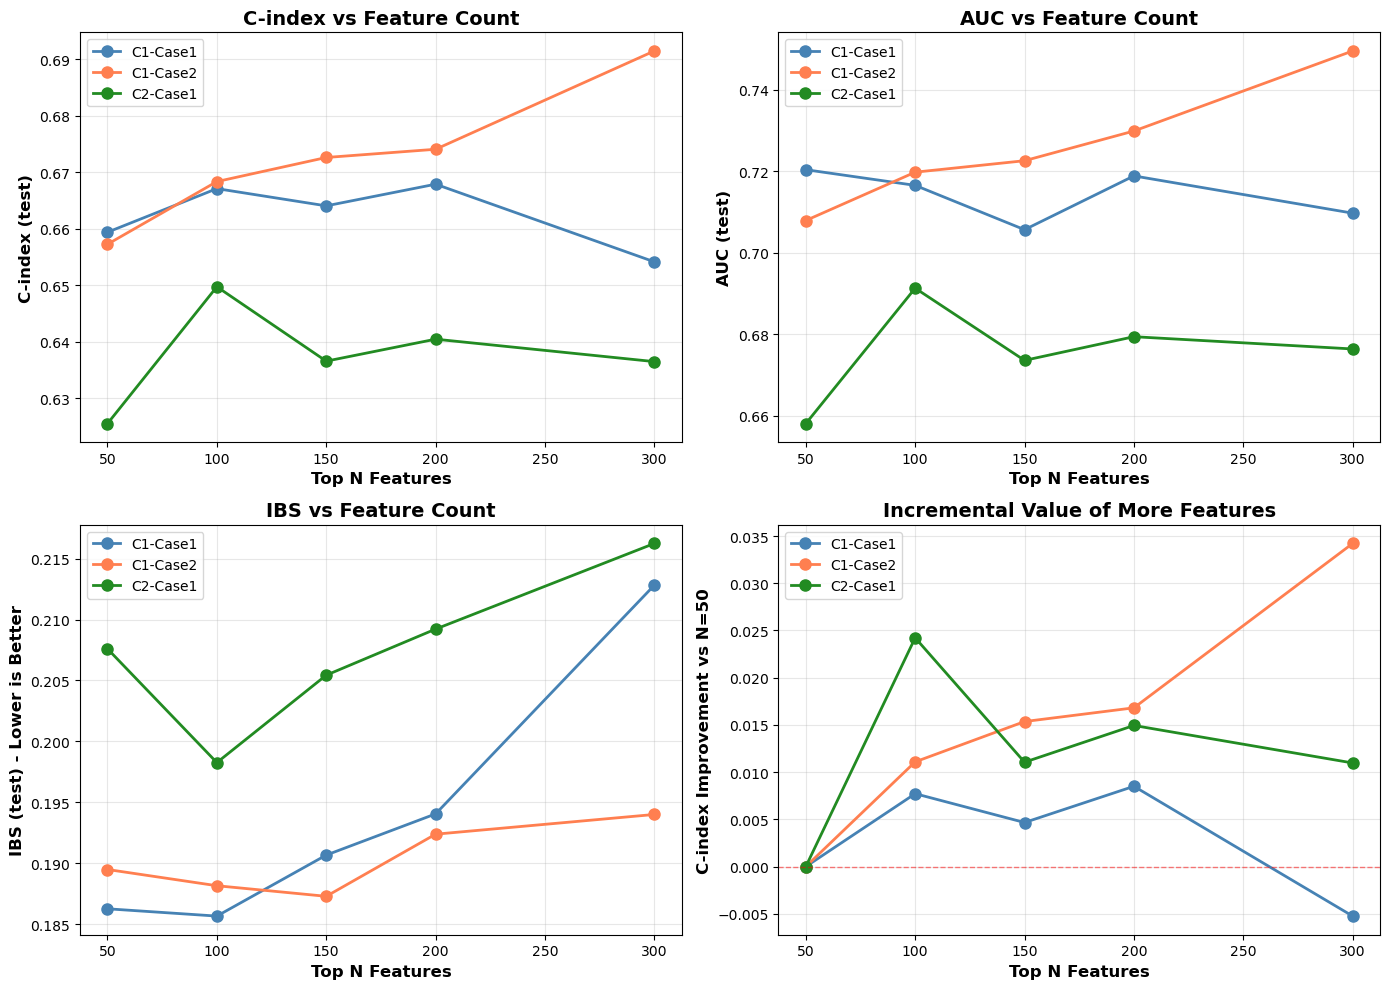


✓ Plots saved to TopN_Sensitivity_Plots.png


In [40]:
####  VISUALIZE PLATEAU EFFECT - q

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

cases = results_df['case'].unique()
colors = ['steelblue', 'coral', 'forestgreen']

# C-index plot
ax = axes[0, 0]
for case, color in zip(cases, colors):
    case_data = results_df[results_df['case'] == case]
    ax.plot(case_data['top_n'], case_data['c_index_test'], 
            marker='o', linewidth=2, markersize=8, label=case, color=color)
ax.set_xlabel('Top N Features', fontsize=12, fontweight='bold')
ax.set_ylabel('C-index (test)', fontsize=12, fontweight='bold')
ax.set_title('C-index vs Feature Count', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# AUC plot
ax = axes[0, 1]
for case, color in zip(cases, colors):
    case_data = results_df[results_df['case'] == case]
    ax.plot(case_data['top_n'], case_data['auc_test'],
            marker='o', linewidth=2, markersize=8, label=case, color=color)
ax.set_xlabel('Top N Features', fontsize=12, fontweight='bold')
ax.set_ylabel('AUC (test)', fontsize=12, fontweight='bold')
ax.set_title('AUC vs Feature Count', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# ## IBS plot (lower is better)
ax = axes[1, 0]
for case, color in zip(cases, colors):
    case_data = results_df[results_df['case'] == case]
    ax.plot(case_data['top_n'], case_data['ibs_test'],
            marker='o', linewidth=2, markersize=8, label=case, color=color)
ax.set_xlabel('Top N Features', fontsize=12, fontweight='bold')
ax.set_ylabel('IBS (test) - Lower is Better', fontsize=12, fontweight='bold')
ax.set_title('IBS vs Feature Count', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# ## Improvement over baseline (50 features)
ax = axes[1, 1]
for case, color in zip(cases, colors):
    case_data = results_df[results_df['case'] == case].sort_values('top_n')
    baseline = case_data[case_data['top_n'] == 50]['c_index_test'].values[0]
    improvement = case_data['c_index_test'] - baseline
    ax.plot(case_data['top_n'], improvement,
            marker='o', linewidth=2, markersize=8, label=case, color=color)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Top N Features', fontsize=12, fontweight='bold')
ax.set_ylabel('C-index Improvement vs N=50', fontsize=12, fontweight='bold')
ax.set_title('Incremental Value of More Features', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}TopN_Sensitivity_Plots.png", dpi=300, bbox_inches='tight')
plt.show()



In [41]:
# IDENTIFY PLATEAU POINTS - so we know the idea N features to select that will preserve much information



for case in cases:
    case_data = results_df[results_df['case'] == case].sort_values('top_n')
    
    print(f"\n{case}:")
    print(f"  N=50:  C-index={case_data[case_data['top_n']==50]['c_index_test'].values[0]:.4f}")
    
    ###  Find where improvement becomes < 0.01 - 
    baseline = case_data[case_data['top_n'] == 50]['c_index_test'].values[0]
    
    for idx, row in case_data.iterrows():
        if row['top_n'] > 50:
            improvement = row['c_index_test'] - baseline
            print(f"  N={row['top_n']:3d}: C-index={row['c_index_test']:.4f} (Δ={improvement:+.4f})")
            
            # # Check if plateau reached
            if improvement < 0.01:
                print(f"  Plateau reached at N={row['top_n']} (improvement < 0.01)")
                break





=============================== PLATEAU ANALYSIS ===============================

C1-Case1:
  N=50:  C-index=0.6594
  N=100: C-index=0.6671 (Δ=+0.0077)
  → Plateau reached at N=100 (improvement < 0.01)

C1-Case2:
  N=50:  C-index=0.6572
  N=100: C-index=0.6683 (Δ=+0.0111)
  N=150: C-index=0.6726 (Δ=+0.0154)
  N=200: C-index=0.6740 (Δ=+0.0168)
  N=300: C-index=0.6914 (Δ=+0.0342)

C2-Case1:
  N=50:  C-index=0.6255
  N=100: C-index=0.6497 (Δ=+0.0242)
  N=150: C-index=0.6365 (Δ=+0.0111)
  N=200: C-index=0.6404 (Δ=+0.0149)
  N=300: C-index=0.6365 (Δ=+0.0110)

================================ RECOMMENDATION ================================


In [42]:
#  # Find optimal N for each case- using the metrcis 
for case in cases:
    case_data = results_df[results_df['case'] == case].sort_values('top_n')
    best_row = case_data.loc[case_data['c_index_test'].idxmax()]
    
    print(f"\n{case}:")
    print(f"  Optimal N: {best_row['top_n']}")
    print(f"  C-index: {best_row['c_index_test']:.4f}")
    print(f"  AUC: {best_row['auc_test']:.4f}")
    print(f"  IBS: {best_row['ibs_test']:.4f}")

print("\n" + "="*80)
print(" COMPLETE! ".center(80, "="))
print("="*80)


C1-Case1:
  Optimal N: 200
  C-index: 0.6679
  AUC: 0.7188
  IBS: 0.1941

C1-Case2:
  Optimal N: 300
  C-index: 0.6914
  AUC: 0.7495
  IBS: 0.1940

C2-Case1:
  Optimal N: 100
  C-index: 0.6497
  AUC: 0.6913
  IBS: 0.1983

================================== COMPLETE! ===================================


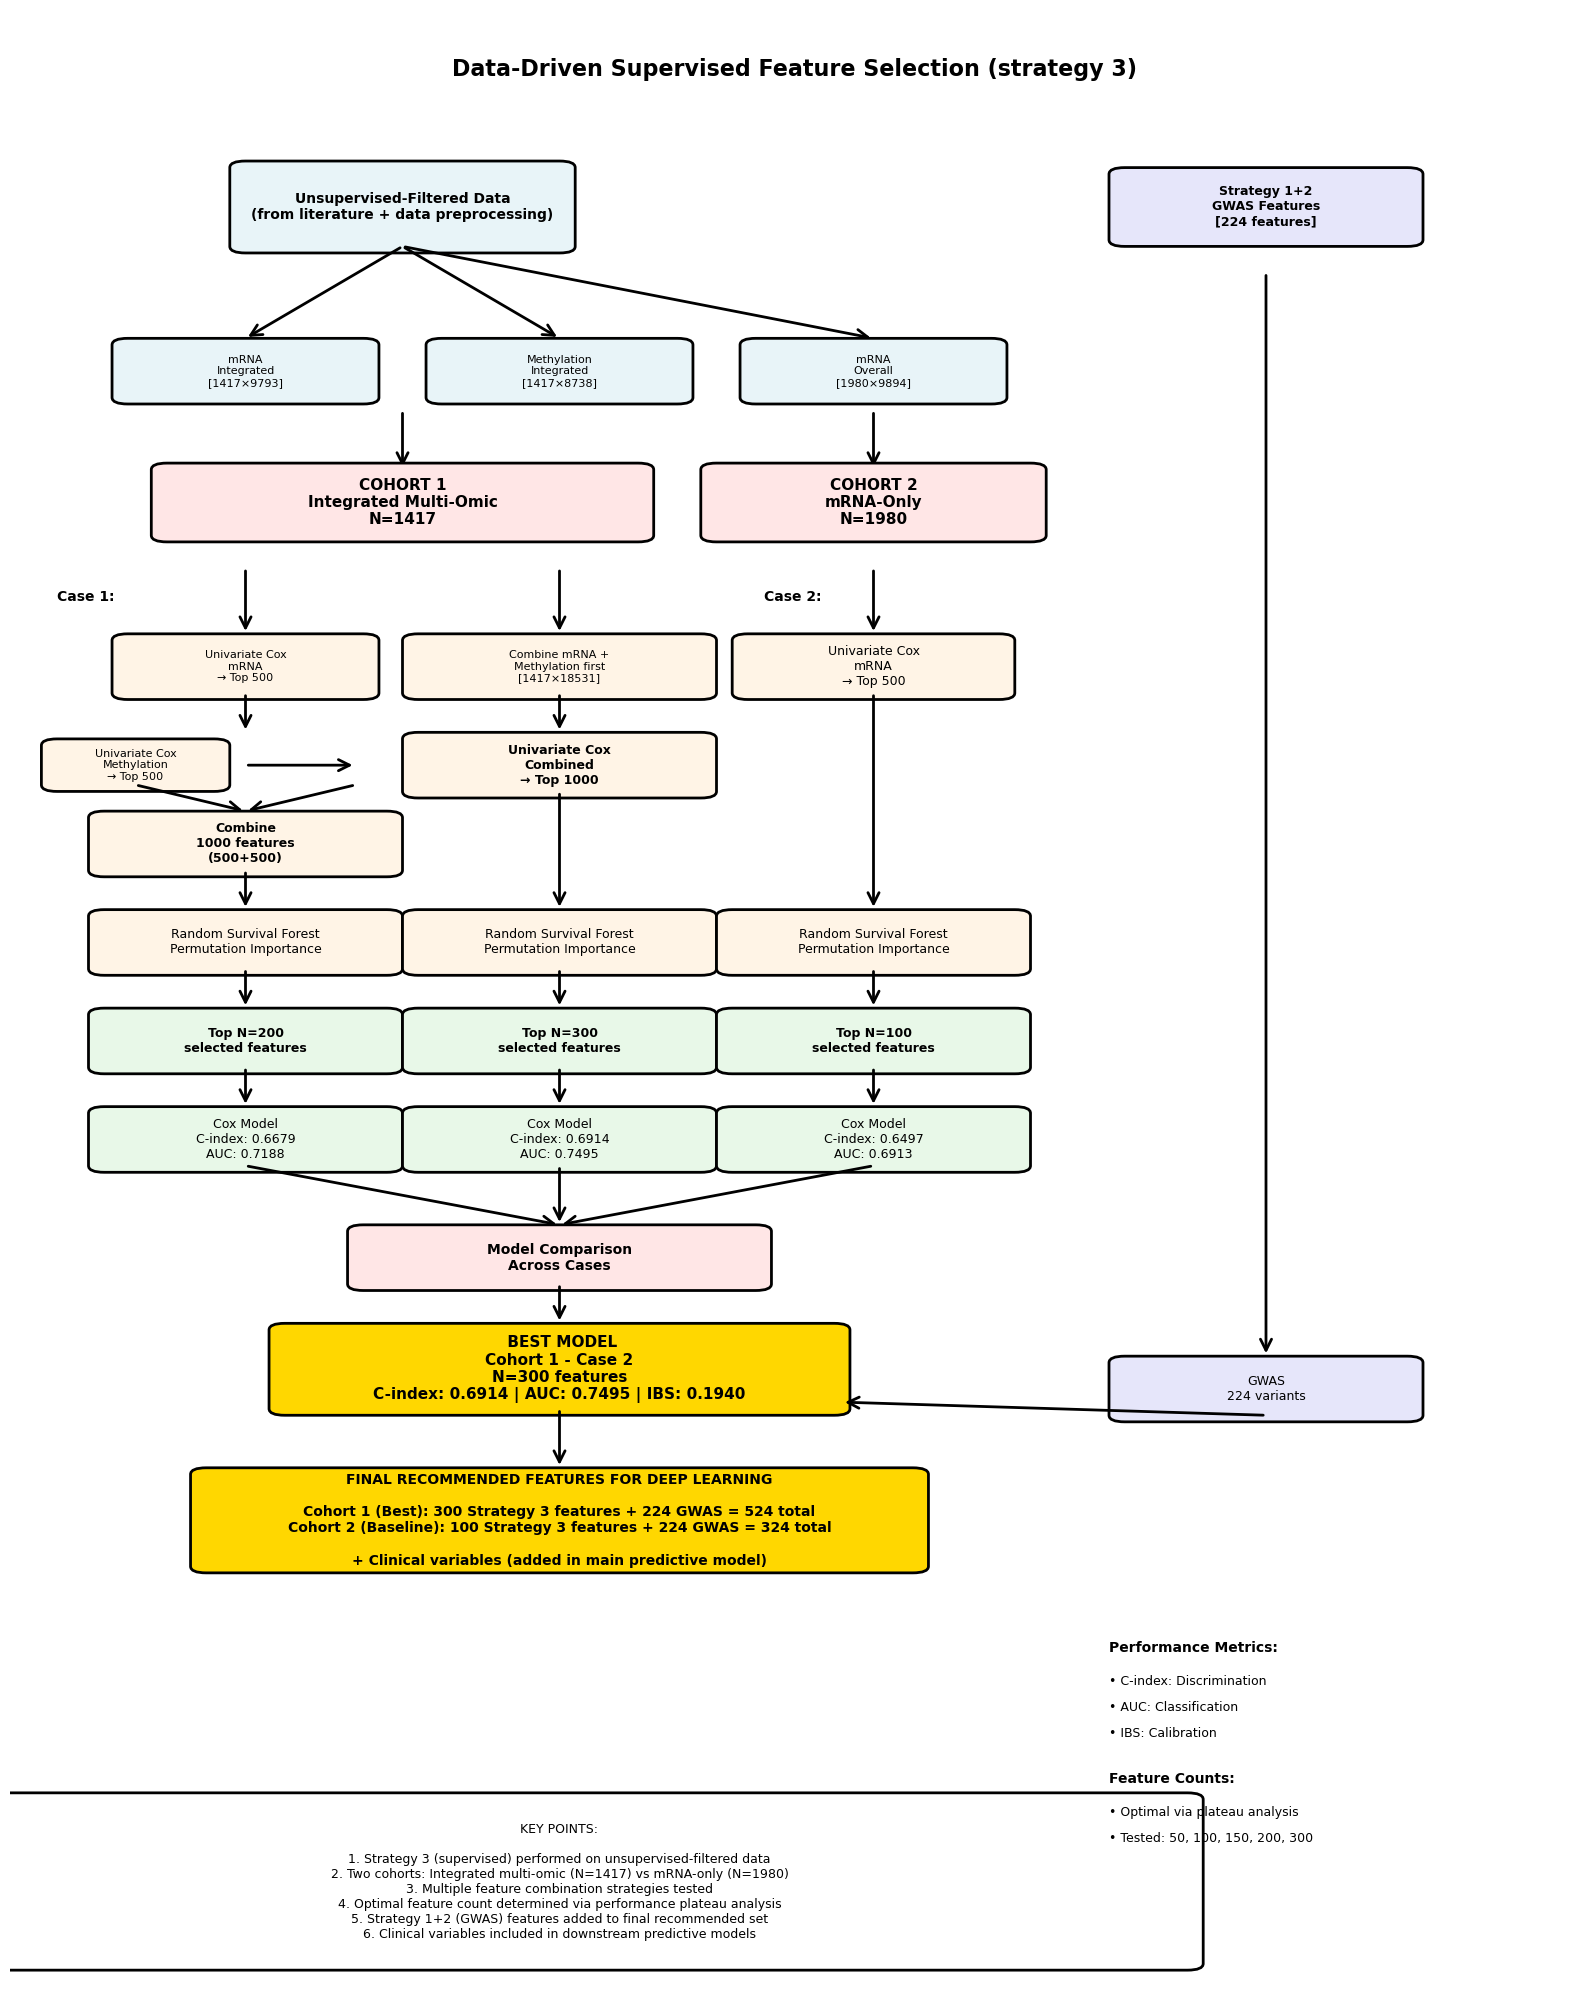


✓ Flowchart saved: Strategy3_Flowchart.png


In [51]:

import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch


# Create figure
fig, ax = plt.subplots(1, 1, figsize=(16, 20))
ax.set_xlim(0, 10)
ax.set_ylim(0, 30)
ax.axis('off')

# Colors
color_data = '#E8F4F8'
color_process = '#FFF4E6'
color_decision = '#FFE6E6'
color_result = '#E8F8E8'
color_final = '#FFD700'

# Helper function for boxes
def add_box(ax, x, y, w, h, text, color, fontsize=10, fontweight='normal'):
    box = FancyBboxPatch((x-w/2, y-h/2), w, h, 
                          boxstyle="round,pad=0.1", 
                          edgecolor='black', 
                          facecolor=color, 
                          linewidth=2)
    ax.add_patch(box)
    ax.text(x, y, text, ha='center', va='center', 
            fontsize=fontsize, fontweight=fontweight, 
            wrap=True, multialignment='center')

# Helper function for arrows
def add_arrow(ax, x1, y1, x2, y2, label=''):
    arrow = FancyArrowPatch((x1, y1), (x2, y2),
                           arrowstyle='->', 
                           mutation_scale=20, 
                           linewidth=2,
                           color='black')
    ax.add_patch(arrow)
    if label:
        mid_x, mid_y = (x1+x2)/2, (y1+y2)/2
        ax.text(mid_x+0.3, mid_y, label, fontsize=9, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Title
ax.text(5, 29, 'Data-Driven Supervised Feature Selection (strategy 3)', 
        ha='center', fontsize=16, fontweight='bold')


# STARTING DATA


add_box(ax, 2.5, 27, 2, 1.2, 
        'Unsupervised-Filtered Data\n(from literature + data preprocessing)', 
        color_data, fontsize=10, fontweight='bold')

# Data branches
add_arrow(ax, 2.5, 26.4, 1.5, 25)
add_arrow(ax, 2.5, 26.4, 3.5, 25)
add_arrow(ax, 2.5, 26.4, 5.5, 25)

add_box(ax, 1.5, 24.5, 1.5, 0.8, 
        'mRNA\nIntegrated\n[1417×9793]', 
        color_data, fontsize=8)

add_box(ax, 3.5, 24.5, 1.5, 0.8, 
        'Methylation\nIntegrated\n[1417×8738]', 
        color_data, fontsize=8)

add_box(ax, 5.5, 24.5, 1.5, 0.8, 
        'mRNA\nOverall\n[1980×9894]', 
        color_data, fontsize=8)


# COHORT SPLIT


add_arrow(ax, 2.5, 23.9, 2.5, 23)
add_arrow(ax, 5.5, 23.9, 5.5, 23)

add_box(ax, 2.5, 22.5, 3, 1, 
        'COHORT 1\nIntegrated Multi-Omic\nN=1417', 
        color_decision, fontsize=11, fontweight='bold')

add_box(ax, 5.5, 22.5, 2, 1, 
        'COHORT 2\nmRNA-Only\nN=1980', 
        color_decision, fontsize=11, fontweight='bold')


# COHORT 1 - CASE 1

add_arrow(ax, 1.5, 21.5, 1.5, 20.5)
ax.text(0.3, 21, 'Case 1:', fontsize=10, fontweight='bold')

add_box(ax, 1.5, 20, 1.5, 0.8, 
        'Univariate Cox\nmRNA\n→ Top 500', 
        color_process, fontsize=8)

add_arrow(ax, 1.5, 19.6, 1.5, 19)

add_box(ax, 0.8, 18.5, 1, 0.6, 
        'Univariate Cox\nMethylation\n→ Top 500', 
        color_process, fontsize=8)

add_arrow(ax, 1.5, 18.5, 2.2, 18.5)
add_arrow(ax, 0.8, 18.2, 1.5, 17.8)
add_arrow(ax, 2.2, 18.2, 1.5, 17.8)

add_box(ax, 1.5, 17.3, 1.8, 0.8, 
        'Combine\n1000 features\n(500+500)', 
        color_process, fontsize=9, fontweight='bold')

add_arrow(ax, 1.5, 16.9, 1.5, 16.3)

add_box(ax, 1.5, 15.8, 1.8, 0.8, 
        'Random Survival Forest\nPermutation Importance', 
        color_process, fontsize=9)

add_arrow(ax, 1.5, 15.4, 1.5, 14.8)

add_box(ax, 1.5, 14.3, 1.8, 0.8, 
        'Top N=200\nselected features', 
        color_result, fontsize=9, fontweight='bold')

add_arrow(ax, 1.5, 13.9, 1.5, 13.3)

add_box(ax, 1.5, 12.8, 1.8, 0.8, 
        'Cox Model\nC-index: 0.6679\nAUC: 0.7188', 
        color_result, fontsize=9)


# COHORT 1 - CASE 2

add_arrow(ax, 3.5, 21.5, 3.5, 20.5)
ax.text(4.8, 21, 'Case 2:', fontsize=10, fontweight='bold')

add_box(ax, 3.5, 20, 1.8, 0.8, 
        'Combine mRNA +\nMethylation first\n[1417×18531]', 
        color_process, fontsize=8)

add_arrow(ax, 3.5, 19.6, 3.5, 19)

add_box(ax, 3.5, 18.5, 1.8, 0.8, 
        'Univariate Cox\nCombined\n→ Top 1000', 
        color_process, fontsize=9, fontweight='bold')

add_arrow(ax, 3.5, 18.1, 3.5, 16.3)

add_box(ax, 3.5, 15.8, 1.8, 0.8, 
        'Random Survival Forest\nPermutation Importance', 
        color_process, fontsize=9)

add_arrow(ax, 3.5, 15.4, 3.5, 14.8)

add_box(ax, 3.5, 14.3, 1.8, 0.8, 
        'Top N=300\nselected features', 
        color_result, fontsize=9, fontweight='bold')

add_arrow(ax, 3.5, 13.9, 3.5, 13.3)

add_box(ax, 3.5, 12.8, 1.8, 0.8, 
        'Cox Model\nC-index: 0.6914\nAUC: 0.7495', 
        color_result, fontsize=9)


# COHORT 2


add_arrow(ax, 5.5, 21.5, 5.5, 20.5)

add_box(ax, 5.5, 20, 1.6, 0.8, 
        'Univariate Cox\nmRNA\n→ Top 500', 
        color_process, fontsize=9)

add_arrow(ax, 5.5, 19.6, 5.5, 16.3)

add_box(ax, 5.5, 15.8, 1.8, 0.8, 
        'Random Survival Forest\nPermutation Importance', 
        color_process, fontsize=9)

add_arrow(ax, 5.5, 15.4, 5.5, 14.8)

add_box(ax, 5.5, 14.3, 1.8, 0.8, 
        'Top N=100\nselected features', 
        color_result, fontsize=9, fontweight='bold')

add_arrow(ax, 5.5, 13.9, 5.5, 13.3)

add_box(ax, 5.5, 12.8, 1.8, 0.8, 
        'Cox Model\nC-index: 0.6497\nAUC: 0.6913', 
        color_result, fontsize=9)


# COMPARISON & BEST MODEL


add_arrow(ax, 1.5, 12.4, 3.5, 11.5)
add_arrow(ax, 3.5, 12.4, 3.5, 11.5)
add_arrow(ax, 5.5, 12.4, 3.5, 11.5)

add_box(ax, 3.5, 11, 2.5, 0.8, 
        'Model Comparison\nAcross Cases', 
        color_decision, fontsize=10, fontweight='bold')

add_arrow(ax, 3.5, 10.6, 3.5, 10)

add_box(ax, 3.5, 9.3, 3.5, 1.2, 
        ' BEST MODEL\nCohort 1 - Case 2\nN=300 features\nC-index: 0.6914 | AUC: 0.7495 | IBS: 0.1940', 
        color_final, fontsize=11, fontweight='bold')


# GWAS INTEGRATION strateg 1+ 2


add_box(ax, 8, 27, 1.8, 1, 
        'Strategy 1+2\nGWAS Features\n[224 features]', 
        '#E6E6FA', fontsize=9, fontweight='bold')

add_arrow(ax, 8, 26, 8, 9.5)

add_box(ax, 8, 9, 1.8, 0.8, 
        'GWAS\n224 variants', 
        '#E6E6FA', fontsize=9)

add_arrow(ax, 8, 8.6, 5.3, 8.8)

# FINAL RECOMMENDED FEATURES

add_arrow(ax, 3.5, 8.7, 3.5, 7.8)

add_box(ax, 3.5, 7, 4.5, 1.4, 
        'FINAL RECOMMENDED FEATURES FOR DEEP LEARNING\n\n' +
        'Cohort 1 (Best): 300 Strategy 3 features + 224 GWAS = 524 total\n' +
        'Cohort 2 (Baseline): 100 Strategy 3 features + 224 GWAS = 324 total\n\n' +
        '+ Clinical variables (added in main predictive model)', 
        color_final, fontsize=10, fontweight='bold')


# LEGEND

ax.text(7, 5, 'Performance Metrics:', fontsize=10, fontweight='bold')
ax.text(7, 4.5, '• C-index: Discrimination', fontsize=9)
ax.text(7, 4.1, '• AUC: Classification', fontsize=9)
ax.text(7, 3.7, '• IBS: Calibration', fontsize=9)

ax.text(7, 3, 'Feature Counts:', fontsize=10, fontweight='bold')
ax.text(7, 2.5, '• Optimal via plateau analysis', fontsize=9)
ax.text(7, 2.1, '• Tested: 50, 100, 150, 200, 300', fontsize=9)

# #NOTES


add_box(ax, 3.5, 1.5, 8, 2.5, 
        'KEY POINTS:\n\n' +
        '1. Strategy 3 (supervised) performed on unsupervised-filtered data\n' +
        '2. Two cohorts: Integrated multi-omic (N=1417) vs mRNA-only (N=1980)\n' +
        '3. Multiple feature combination strategies tested\n' +
        '4. Optimal feature count determined via performance plateau analysis\n' +
        '5. Strategy 1+2 (GWAS) features added to final recommended set\n' +
        '6. Clinical variables included in downstream predictive models',
        'white', fontsize=9)

plt.tight_layout()
plt.savefig('/Users/joshkorley/Documents/ENAR_project/Strategy3_Flowchart.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Flowchart saved: Strategy3_Flowchart.png")

In [43]:
import pickle

# Save all your workspace and important variables
workspace = {
    'X_meth_integrated': X_meth_integrated,
    'X_mRNA_integrated': X_mRNA_integrated,
    'X_mRNA_overall': X_mRNA_overall,
    'clinical_c1': clinical_c1,
    'clinical_c2': clinical_c2,
    'y_c1': y_c1,
    'y_c2': y_c2,
    
    
    'cox_mrna_c1': cox_mrna_c1 if 'cox_mrna_c1' in locals() else None,
    'cox_meth_c1': cox_meth_c1 if 'cox_meth_c1' in locals() else None,
    
    #
    'TOP_N_FEATURES': TOP_N_FEATURES,
    'OUTPUT_DIR': OUTPUT_DIR
}

# 
with open(f'{OUTPUT_DIR}strategy3_workspace.pkl', 'wb') as f:
    pickle.dump(workspace, f)

print("✓ Workspace saved!")

✓ Workspace saved!


In [ ]:

## just lopading workspace ... not needed though 
import pickle

# Load everything back
with open(f'{OUTPUT_DIR}strategy3_workspace.pkl', 'rb') as f:
    workspace = pickle.load(f)

# Extract variables
X_meth_integrated = workspace['X_meth_integrated']
X_mRNA_integrated = workspace['X_mRNA_integrated']
X_mRNA_overall = workspace['X_mRNA_overall']
clinical_c1 = workspace['clinical_c1']
clinical_c2 = workspace['clinical_c2']
y_c1 = workspace['y_c1']
y_c2 = workspace['y_c2']
TOP_N_FEATURES = workspace['TOP_N_FEATURES']
OUTPUT_DIR = workspace['OUTPUT_DIR']

print("✓ Workspace loaded!")